## Real data

In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#import scipy.optimize as optimize

In [2]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=2):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('<H', chunk)[0]
            else:
                break    


# Read the specified number of images from the given file.
# Each "image" is the difference between two 512x512 "pre"-images
#  read in succession. Each image is median subtracted.
def read_images(datfile,nimages):
    
    # Create a reader.
    freader = iter(bytes_from_file(datfile))

    # Read 4-byte header.
    for i in range(2):
        next(freader)

    # Read the images.
    imgs = []
    for ni in range(nimages):

        img1 = []
        for i in range(512*512):
            img1.append(next(freader))

        img2 = []
        for i in range(512*512):
            img2.append(next(freader))

        imgs.append(np.array(img2).reshape([512,512]) - np.array(img1).reshape([512,512]))

    # Return the final image array in numpy format.
    imgs = np.array(imgs)
    imgs = imgs - np.median(imgs,axis=0)
    
    return imgs

#### Read the images

In [3]:
datfile = "/home/jrenner/local/data/4dstem/scan_0000001768/team1k_ued_0000001768_0000000006.dat"
imgs = read_images(datfile,2048)

#### Show the final processed image

In [4]:
# Average over all images to get the "processed" image.
img_proc = np.average(imgs,axis=0)

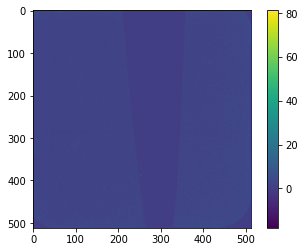

In [5]:
plt.imshow(img_proc)
plt.colorbar()

#### Histogram individual image elements to determine threshold

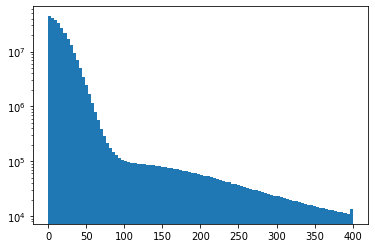

In [6]:
# Create a histogram of all image elements.
plt.hist(imgs.flatten(),bins=100,range=[0,400])
plt.yscale("log")

In [7]:
# Create a thresholded image.
th = 100
imgs_th = np.zeros(imgs.shape)
imgs_th[imgs > th] = imgs[imgs > th]

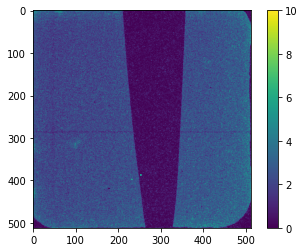

In [10]:
# Show the thresholded image.
img_th_proc = np.average(imgs_th,axis=0)
plt.imshow(img_th_proc,vmax=10)
plt.colorbar()

#### Fit the edge of the thresholded image for each row

In [11]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# Fit an s-curve to the specified row in img,
#  within a range of +/- rng centered upon x0.
def fit_scurve(img,nrow,x0,rng=50):
    
    # Choose the row, selecting elements (x0-rng):(x0+rng)
    xmin = max(0,x0-rng)
    xmax = min(img.shape[1],x0+rng)
    ydata = img[nrow,xmin:xmax]
    xdata = np.arange(xmin,xmax)

    # Set an initial guess and perform the fit.
    p0 = [np.mean(ydata[ydata > np.mean(ydata)]), x0, 1, min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox', bounds=((-max(ydata), x0-10, -np.inf, 0), (max(ydata), x0+10, np.inf, 100)))
    
    return popt

In [12]:
x_guess = 210
x_edges = []
for row in range(img_th_proc.shape[0]):
    
    # Perform the fit.
    L,x0,k,b = fit_scurve(img_th_proc,row,x_guess)
    
    x_edge = int(np.round(x0))
    x_edges.append(x_edge)
    x_guess = x_edge
    print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
x_edges = np.array(x_edges)

/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


-- Fit row 0 : L= -3.2300090065189746 x0= 210.9043108171701 k= 26.104660446953805 b= 3.540458904110595
-- Fit row 1 : L= -2.6007310503744203 x0= 210.0116719928109 k= 20.235655917058295 b= 2.879966404268286
-- Fit row 2 : L= -2.9044066684420256 x0= 210.31973779603544 k= 1.0720140483304175 b= 3.063082456644729
-- Fit row 3 : L= -2.754817065679102 x0= 210.43770935839132 k= 0.7491669676178866 b= 2.9809928593261072
-- Fit row 4 : L= -2.646326114224313 x0= 207.70655005573056 k= 0.40027692783639296 b= 2.908260309878636
-- Fit row 5 : L= -2.7565746332169097 x0= 210.91860959672508 k= 30.91713659142888 b= 2.9632207072906334
-- Fit row 6 : L= -2.298151467635409 x0= 210.05249841908704 k= 22.362051013625752 b= 2.6449323401510525
-- Fit row 7 : L= -2.6461858205850417 x0= 210.0315630185407 k= 1.2358939677233478 b= 2.8459701182870534
-- Fit row 8 : L= -2.4869663665688493 x0= 210.5441223462354 k= 39.80521586590844 b= 2.7041775588306294
-- Fit row 9 : L= -2.5185947693417607 x0= 210.04407371989745 k= 12.

-- Fit row 83 : L= 2.045917158748763 x0= 215.97208726493668 k= -26.939835777382147 b= 0.24076854226688235
-- Fit row 84 : L= -1.6215926421749725 x0= 216.05537344290514 k= 29.88255658494469 b= 1.9169540670357945
-- Fit row 85 : L= -1.6980444175005032 x0= 216.00508289276834 k= 22.652661034574624 b= 2.105050100040478
-- Fit row 86 : L= -1.749484016262758 x0= 216.11214895017986 k= 33.9558001863253 b= 2.052138671875
-- Fit row 87 : L= -1.707751514668372 x0= 216.08610784912273 k= 32.441954479234326 b= 2.03306640625
-- Fit row 88 : L= -1.889440386651627 x0= 216.96491958558784 k= 2.6529047614433994 b= 2.1873483192502805
-- Fit row 89 : L= -1.8179233355950486 x0= 215.17277666893213 k= 0.710780881717243 b= 2.16273797014359
-- Fit row 90 : L= -1.9132790008346094 x0= 216.97055017266916 k= 18.561274411306975 b= 2.215332537463115
-- Fit row 91 : L= -1.6041259980479432 x0= 216.96067845679414 k= 0.6065253779307178 b= 1.9289236243896501
-- Fit row 92 : L= -2.0717410017428888 x0= 215.58471406977523 k= 0

-- Fit row 164 : L= 2.006118761957908 x0= 223.0603826281985 k= -37.32207951529427 b= 0.3935247927295919
-- Fit row 165 : L= -1.9160381101850974 x0= 222.93687249279222 k= 16.80312968599165 b= 2.297087752048376
-- Fit row 166 : L= -1.9658440290179173 x0= 222.9702077347798 k= 28.217611943082176 b= 2.3157324218750506
-- Fit row 167 : L= -1.9615481627379656 x0= 223.0333992100647 k= 1.6980381897776395 b= 2.1422567293138126
-- Fit row 168 : L= -2.1147139876008 x0= 221.88200573220183 k= 0.8085092306753346 b= 2.3912973869648915
-- Fit row 169 : L= 1.716769242568817 x0= 223.2567320983831 k= -3.4877524563069726 b= 0.30315515825730965
-- Fit row 170 : L= -1.7736750584022762 x0= 223.91158021028068 k= 31.77077540980864 b= 2.1528559666054012
-- Fit row 171 : L= -2.0828750285385547 x0= 223.37636442530737 k= 1.9105324899565679 b= 2.325303505507756
-- Fit row 172 : L= -1.8534811362629688 x0= 223.7754956868546 k= 0.9010765554143032 b= 2.232386605531047
-- Fit row 173 : L= -1.9406041082584322 x0= 222.1684

-- Fit row 246 : L= -2.3798349808673724 x0= 230.9471902343495 k= 29.859470581903352 b= 2.6915527343750245
-- Fit row 247 : L= -2.116666002295794 x0= 229.71616528360846 k= 1.8954857619887726 b= 2.4254926015917206
-- Fit row 248 : L= -1.8959593686307479 x0= 231.40653332259024 k= 36.867708753322745 b= 2.1261012093902134
-- Fit row 249 : L= -1.9173195429823586 x0= 230.54008943214433 k= 2.3135389215048363 b= 2.222058839107639
-- Fit row 250 : L= -1.75472833583858 x0= 230.97139022751225 k= 21.035634181205193 b= 2.136643226561943
-- Fit row 251 : L= -2.1098886349987946 x0= 230.74145589221882 k= 1.1159391981566738 b= 2.3805676454607325
-- Fit row 252 : L= -1.8754902287567192 x0= 232.9001043094324 k= 32.8111703213563 b= 2.1535540787556657
-- Fit row 253 : L= -1.927859939087218 x0= 231.50170580756188 k= 42.96201549749118 b= 2.2267517917602446
-- Fit row 254 : L= -1.9843309874385595 x0= 231.03878258639185 k= 23.43404456588852 b= 2.2856796319593435
-- Fit row 255 : L= -2.0345838254916044 x0= 231.3

-- Fit row 329 : L= -2.0923112643495254 x0= 239.99997204915175 k= 28.496588015531557 b= 2.438173828125018
-- Fit row 330 : L= -2.132481972973969 x0= 239.98438402305348 k= 28.959673207549756 b= 2.4498041496247493
-- Fit row 331 : L= 2.2917652022895676 x0= 240.77372333534646 k= -3.8416043093540324 b= 0.34387260073010006
-- Fit row 332 : L= -2.059504009917077 x0= 239.87763507060902 k= 1.9957881051145003 b= 2.344427230702318
-- Fit row 333 : L= -2.0072852294527386 x0= 240.81589402563085 k= 13.974629484944668 b= 2.3401771604857093
-- Fit row 334 : L= -2.1227026392538106 x0= 240.9463464797665 k= 21.29790212729769 b= 2.3609957839995217
-- Fit row 335 : L= -2.0451421036838693 x0= 240.35489358184552 k= 0.6036613342675763 b= 2.2925601685748895
-- Fit row 336 : L= -2.007825495122994 x0= 242.12900630341008 k= 1.7251305989780372 b= 2.31632106362523
-- Fit row 337 : L= -2.0711953531571456 x0= 241.14245840752326 k= 2.0139967904335117 b= 2.3859540181721717
-- Fit row 338 : L= -2.128314444305304 x0= 24

-- Fit row 415 : L= -1.8050798734055071 x0= 252.43448068884024 k= 0.748200138487388 b= 2.1869066422063983
-- Fit row 416 : L= -2.0610378358589507 x0= 250.5393062122325 k= 2.9192012720159535 b= 2.367966290582587
-- Fit row 417 : L= -2.1678932493121303 x0= 251.68133384525854 k= 4.048805253796833 b= 2.3949915196499036
-- Fit row 418 : L= -2.2374099910803746 x0= 251.60878810195405 k= 43.983762284561315 b= 2.67986199057593
-- Fit row 419 : L= -2.068784677933683 x0= 251.11885365305574 k= 33.01979618380902 b= 2.6079350685586737
-- Fit row 420 : L= -2.572141524740844 x0= 251.070401939975 k= 0.6812417654601428 b= 2.864873338366878
-- Fit row 421 : L= -2.28215797743909 x0= 251.03700191348895 k= 17.382677192175073 b= 2.5851044276527855
-- Fit row 422 : L= -2.214389528191238 x0= 251.68803309900707 k= 2.034380813881069 b= 2.552758079493386
-- Fit row 423 : L= -1.8483592543139196 x0= 252.55040669895862 k= 47.95406104654358 b= 2.2593129276418313
-- Fit row 424 : L= -2.059062516092451 x0= 251.95495867

-- Fit row 496 : L= -2.4047320659360256 x0= 260.9362546368921 k= 1.6652686343112288 b= 2.765032519363323
-- Fit row 497 : L= -2.5502206054229903 x0= 260.48385901504224 k= 0.8658725669176954 b= 2.7906928318622115
-- Fit row 498 : L= -2.456417764802911 x0= 260.06159290987745 k= 0.46914637605710074 b= 2.8681418417457447
-- Fit row 499 : L= -2.803102731783976 x0= 262.9430301057421 k= 0.593833406273817 b= 3.0414044409759344
-- Fit row 500 : L= -2.636880377942266 x0= 262.08375193121185 k= 2.4902607598361532 b= 2.9096044114759896
-- Fit row 501 : L= 2.6408744286565558 x0= 262.6468348710191 k= -37.28371749640389 b= 0.22770488080549123
-- Fit row 502 : L= -2.8862864538543858 x0= 262.3896937284657 k= 2.8685637865033113 b= 3.174027360096219
-- Fit row 503 : L= -3.025846870193731 x0= 262.57160975696934 k= 4.5404195709585435 b= 3.375509508215079
-- Fit row 504 : L= -2.7527410174407354 x0= 262.97745478112074 k= 20.591735930507486 b= 3.0227218441552295
-- Fit row 505 : L= -2.9743146764368986 x0= 262.

##### Plot the edge

In [13]:
img_edge = np.zeros(img_th_proc.shape)
for row,iedge in zip(range(img_edge.shape[0]),x_edges):
    img_edge[row,iedge] = 1

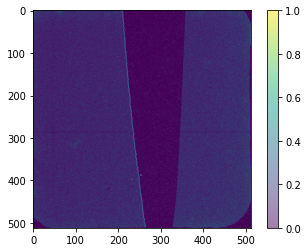

In [23]:
plt.imshow(img_th_proc,vmax=10)
plt.imshow(img_edge,alpha=0.5)
plt.colorbar()

##### Test a single fit

In [ ]:
row = 10
x_guess = 200
rng = 50

popt = fit_scurve(img_th_proc,row,x_guess)

xmin = max(0,x_guess-rng)
xmax = min(img_th_proc.shape[1],x_guess+rng)
ydata = img_th_proc[row,xmin:xmax]
xdata = np.arange(xmin,xmax)

x = np.linspace(xdata[0], xdata[-1], 1000)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')

print("-- Fit row",row,": popt =",popt)
print(np.mean(ydata[ydata > np.mean(ydata)]))

##### Select the images using the edge array

In [25]:
# Copy the edge array.
available_edges = np.copy(x_edges)

In [26]:
# For each individual thresholded image, choose the sub-images.
for iimg in range(1): #len(imgs_th.shape[0]))
    img = imgs_th[iimg]

array([211, 210, 210, 210, 208, 211, 210, 210, 211, 210, 211, 211, 211,
       211, 209, 211, 210, 211, 212, 212, 212, 212, 210, 211, 212, 212,
       212, 211, 212, 212, 212, 212, 213, 213, 212, 213, 213, 212, 212,
       213, 213, 214, 214, 214, 213, 213, 212, 216, 213, 213, 213, 214,
       214, 214, 214, 213, 215, 214, 215, 214, 214, 214, 215, 214, 215,
       215, 214, 215, 216, 215, 217, 216, 216, 215, 216, 215, 216, 217,
       216, 216, 215, 215, 216, 216, 216, 216, 216, 216, 217, 215, 217,
       217, 216, 217, 216, 217, 217, 218, 218, 218, 218, 218, 217, 218,
       218, 218, 219, 218, 218, 218, 219, 219, 217, 215, 218, 219, 219,
       219, 219, 219, 219, 219, 220, 218, 219, 220, 219, 219, 220, 220,
       220, 220, 220, 220, 221, 221, 220, 220, 221, 221, 221, 221, 221,
       222, 222, 221, 221, 222, 222, 221, 222, 222, 222, 222, 220, 223,
       222, 222, 222, 223, 223, 223, 223, 223, 223, 223, 223, 223, 222,
       223, 224, 223, 224, 222, 224, 224, 224, 224, 224, 224, 22

## Backup code

In [ ]:
ydata = img_th_proc[480,208:308]
xdata = np.arange(len(ydata)) + 208

p0 = [max(ydata), np.median(xdata), 1, min(ydata)] # this is an mandatory initial guess
popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

x = np.linspace(xdata[0], xdata[-1], 1000)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')
print("Best fit parameters: L = {}, x0 = {}, k = {}, b = {}".format(popt[0],popt[1],popt[2],popt[3]))

In [ ]:
#plt.imshow(np.average(imgs_medsub,axis=0))
plt.imshow(imgs_th[0][0:11,0:11])
plt.colorbar()

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [ ]:
# Read a new dataset.
df = emsim_utils.read_electron_data(datfile,nevts=200005)
df.to_pickle("EM_4um_back_10M_300keV.pkl")

In [ ]:
len(df.event.unique())

# Generate random multi-electron events

In [ ]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

In [ ]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0, res_factor=3)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [ ]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 80):
    
    A = fit_img/np.mean(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,2.0*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Force m and b.
    m = -2.0
    b = 90.0
    print("NOTE: hard-coding m and b")
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (5./3.)*(m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

# Fit the S-curve to a sigmoid.
def fit_scurve():
    

In [ ]:
# Create some number of events and count them.
th_unet = 0.2
th_classical = 825/4.
evts = np.arange(0,100000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    gnd_truth = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    
    # Max argument classical truth.
    #ct_classical = np.zeros(frame.shape)
    #ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    # Threshold truth.
    ct_classical = label[1]
    
    l_frames.append(frame)
    l_labels.append(gnd_truth)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

In [ ]:
raw_th = 0.99
ct_th = 0.1
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

In [ ]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    #plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame (log counts)\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    #plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
#plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.title("Truth\nm = {:.2f}, b = {:.2f}".format(m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
#plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.title("UNet counts\nm = {:.2f}, b = {:.2f}".format(m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
#plt.title("Classical counts + line info (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.title("Classical counts + line info\nm = {:.2f}, b = {:.2f}".format(m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

print("Total counts, truth:",np.sum(label))
print("Total counts, classical:",np.sum(ct_classical))
print("Total counts, unet:",np.sum(ct_unet))

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(hdist_frame))

ax1 = fig.add_subplot(121)
plt.plot(bcenters_frame,frame_mult*(hdist_frame-min(hdist_frame)),'.-',color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical+line')
plt.xlim([-10,10])
plt.ylim([0.0,3.2])
plt.xlabel("Distance from line (micrometers)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
# Save s-curve information.
np.savez("scurve_edge_th02_epoch10.npz", bcenters_frame=bcenters_frame, hdist_frame=hdist_frame, bcenters_label=bcenters_label, hdist_label=hdist_label, 
         bcenters_unet=bcenters_unet, hdist_unet=hdist_unet, bcenters_classical=bcenters_classical, 
         hdist_classical=hdist_classical)

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

#### Plot s-curve data

In [ ]:
scurve_noedge = np.load("scurve_noedge_th088.npz")
bc_label_noedge = scurve_noedge['bcenters_label']
h_label_noedge = scurve_noedge['hdist_label']
bc_unet_noedge = scurve_noedge['bcenters_unet']
h_unet_noedge = scurve_noedge['hdist_unet']
bc_classical_noedge = scurve_noedge['bcenters_classical']
h_classical_noedge = scurve_noedge['hdist_classical']

scurve_edge = np.load("scurve_edge_th08.npz")
bc_frame_edge = scurve_edge['bcenters_frame']
h_frame_edge = scurve_edge['hdist_frame']
bc_label_edge = scurve_edge['bcenters_label']
h_label_edge = scurve_edge['hdist_label']
bc_unet_edge = scurve_edge['bcenters_unet']
h_unet_edge = scurve_edge['hdist_unet']
bc_classical_edge = scurve_edge['bcenters_classical']
h_classical_edge = scurve_edge['hdist_classical']

scurve_edge10 = np.load("scurve_edge_th08_epoch10.npz")
bc_label_edge10 = scurve_edge10['bcenters_label']
h_label_edge10 = scurve_edge10['hdist_label']
bc_unet_edge10 = scurve_edge10['bcenters_unet']
h_unet_edge10 = scurve_edge10['hdist_unet']
bc_classical_edge10 = scurve_edge10['bcenters_classical']
h_classical_edge10 = scurve_edge10['hdist_classical']

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(h_frame_edge))

ax1 = fig.add_subplot(111)
plt.plot(bc_frame_edge,frame_mult*(h_frame_edge-min(h_frame_edge)),'.-',color='black',label='raw frame, scaled')
plt.plot(bc_classical_edge,h_classical_edge,'.-',color='red',label='classical')
plt.plot(bc_unet_noedge,h_unet_noedge,'.-',color='orange',label='UNet, no edge, epoch 500')
plt.plot(bc_unet_edge10,h_unet_edge10,'.-',color='cyan',label='UNet + edge, epoch 11')
plt.plot(bc_unet_edge,h_unet_edge,'.-',color='blue',label='UNet + edge, epoch 500')
plt.plot(bc_label_edge,h_label_edge,'.-',color='green',label='true')
plt.xlim([-5,5])
plt.ylim([0.0,1.0])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/model_init_199.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=3)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_unet(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_edge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [ ]:
sigmoid = nn.Sigmoid()
#dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

In [ ]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600/4,7000/4,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

In [ ]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.02])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [ ]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

In [ ]:
evt_plt = 10008
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
#modeldir = '/home/jrenner/local/jerenner/emsim/models'\
modeldir = '/home/jrenner/temp/nersc'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/run_11x11_chi32_60/model_init_599.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        val_loss = tr.val(model, epoch, val_loader)
        scheduler.step(val_loss)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_short_training_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/train.txt")
vloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/val.txt")
#vloss = np.loadtxt("/home/jrenner/local/jerenner/emsim/val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(100000,110000)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
xvals = df['xc_3x3'].values
yvals = df['yc_3x3'].values
rngval = 0.002
plt.hist2d(xvals,yvals,bins=10,range=[[-rngval,rngval],[-rngval,rngval]])
plt.colorbar()

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.1
rng_cut = 0.005
sigma_cut = 1e9
nbins = 50

df_plt_NN  = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]
df_plt_3x3 = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]

plt.hist(df_plt_NN.error_r_NN,range=(0,rng_cut),alpha=0.8,bins=nbins,color='blue',label='NN error')
plt.hist(df_plt_3x3.error_r_3x3,range=(0,rng_cut),alpha=0.8,bins=nbins,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
#plt.yscale('log')
plt.legend()

print("NN events:",len(df_plt_NN[df_plt_NN.error_r_NN < rng_cut]))
print("3x3 events:",len(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut]))
print("Mean NN error:",np.mean(df_plt_NN[df_plt_NN.error_r_NN < rng_cut].error_r_NN))
print("Mean 3x3 error:",np.mean(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut].error_r_3x3))

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
df[df.x_true > 0.02][['event','x_true']]

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 80388
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN # - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX # + dset.add_shift*emnet.PIXEL_SIZE
#ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE
ERR_PIXEL_SIZE = (emnet.PIXEL_ERR_RANGE_MAX - emnet.PIXEL_ERR_RANGE_MIN)/emnet.ERR_SIZE
print("Error grid pixel size is {}".format(ERR_PIXEL_SIZE))

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
print(x_errgrid)

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))